<a href="https://colab.research.google.com/github/sarthak-314/Book-Recommender-System/blob/master/Neural%20Collaborative%20Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Neural Collaborative Filtering** with Keras
***

In [ ]:
import pandas as pd
import os
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
DF_PATH = './Colab Notebooks/CADABRA/Recommender System/goodreads-10k'
ratings = pd.read_csv(os.path.join(DF_PATH, 'ratings.csv'))

In [ ]:
ratings.rating.value_counts()

4    2139018
5    1983093
3    1370916
2     359257
1     124195
Name: rating, dtype: int64

**Combining 1 star, 2 star and 3 star ratings**

The ratings for the books are heavily skewed towards 4 star (2.1M) and 5 star (1.98M) ratings

There are not that many 1 star (124K) and 2 star (359 K) ratings in the dataset. So I balance out the ratings by combining 1 star, 2 star and 3 star ratings (total=1.8M) into one feature. This way all the columns will have close to 2 million ratings availible and the dataset will be balanced

In [ ]:
#One Hot encoding along with combining 1, 2, 3 star ratings

#5 star ratings go into loved_book column
ratings['loved_book'] = (ratings.rating == 5).astype(int)
#4 star ratings go into liked_book column
ratings['liked_book'] = (ratings.rating == 4).astype(int)
#Ratings less than 4 go into did_not_like column
ratings['did_not_like'] = (ratings.rating < 4).astype(int)

ratings.head()

,user_id,book_id,rating,loved_book,liked_book,did_not_like
0,1,258,5,1,0,0
1,2,4081,4,0,1,0
2,2,260,5,1,0,0
3,2,9296,5,1,0,0
4,2,2318,3,0,0,1


In [ ]:
TOTAL_USERS = ratings.user_id.nunique()
TOTAL_BOOKS = ratings.book_id.nunique()

In [ ]:
import numpy as np
X = np.stack([ratings.user_id.values, ratings.book_id.values], axis=-1)
Y = np.stack([ratings.loved_book, ratings.liked_book, ratings.did_not_like], axis=-1)

In the dataset, user_id and book_id start from 1. But numpy and python follow a 0-based indexing rule. So user_id = 1 will be at row = 0, user_id = 2 at row = 1 and so on

Therefore I **subtract 1 from user_id and book_id**, so that they become zero indexed as well and I can referace them by their index 

In [ ]:
X[:, 0] -= 1
X[:, 1] -= 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y)

In [ ]:
import keras
from keras.models import Model
from keras.regularizers import l2
from keras import layers

![title](https://miro.medium.com/max/1952/1*aP-Mx266ExwoWZPSdHtYpA.png)


Making the model (based on [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf))

In [ ]:
class BookRecommender(Model):
    def __init__(self, num_users, num_books, embedding_dim):
        super().__init__()
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_dim = embedding_dim
        
        #The paper uses random initialization, but I use he_normal 
        #because it gives better accuracy for a small change
        self.user_embedding = layers.Embedding(num_users, embedding_dim,
                                                embeddings_initializer='he_normal',
                                                embeddings_regularizer=l2(0.001))
        
        #Performance of the model can be improved by adding user and book bias terms
        #If Yash normally rates the books between 1-3 stars, but he gave some book 5 star, he must really love it!
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(num_books, embedding_dim, 
                                               embeddings_initializer='he_normal',
                                               embeddings_regularizer=l2(0.001))
        
        self.book_bias = layers.Embedding(num_books, 1)
        classes = ['loved_book', 'liked_book', 'did_not_like']
        #Freestyling the number of neurons
        self.lin_1 = layers.Dense(2, activation='relu')
        self.lin_2 = layers.Dense(4, activation='relu')
        self.out_lin = layers.Dense(len(classes), activation='relu')
        self.drop_1 = layers.Dropout(0.5)
        self.drop_2 = layers.Dropout(0.3)
    '''
    Instead of passing sparse user vector and a sparse book vector, I pass
    the user and book as a pair, so ignore the first layer of the digram
    '''
    def call(self, ratings, training=False): 
        user_vector = self.user_embedding(ratings[:, 0])
        user_bias = self.user_bias(ratings[:, 0])
        book_vector = self.book_embedding(ratings[:, 1])
        book_bias = self.book_bias(ratings[:, 1])
        #User-book interaction
        user_book_dot = layers.Dot(1)([user_vector, book_vector])
        x = user_book_dot + user_bias + book_bias
        if training:
            x = self.lin_2(self.drop_1(self.lin_1(x)))
            x = self.drop_2(x)
        else: 
            x = self.lin_2(self.lin_1(x))    
        x = self.out_lin(x)
        #Softmax to get probabilities
        output = layers.Softmax()(x)
        return output

In [ ]:
import keras
from keras.losses import CategoricalCrossentropy
#50 causes overfitting
EMBEDDING_DIM = 20
model = BookRecommender(TOTAL_USERS, TOTAL_BOOKS, EMBEDDING_DIM)
#Adam optimizer used in the paper
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=0.001))

In [ ]:
BATCH_SIZE = 100000
EPOCHS = 1

In [ ]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, Y_test)
)

45/45 [==============================] - 2s 37ms/step - loss: 1.0877 - val_loss: 1.0845


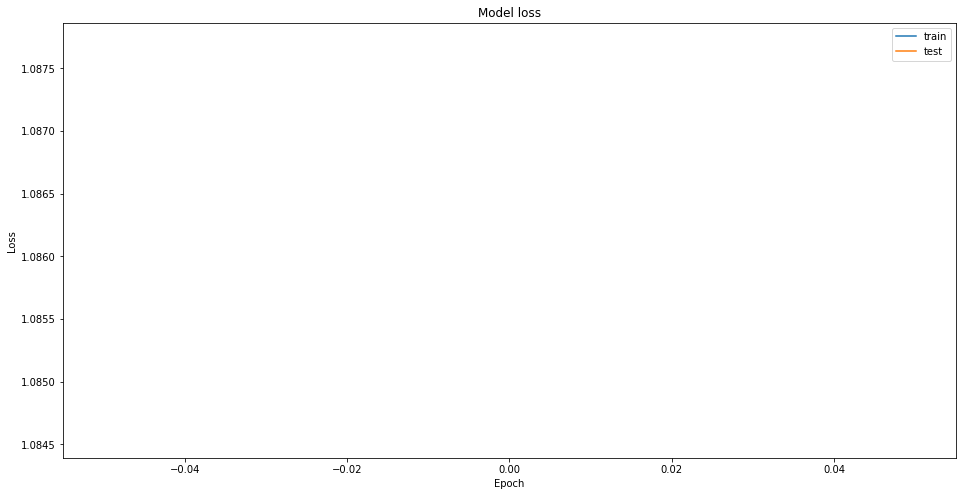

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "test"])
plt.show()

Let's save the model

In [ ]:
SAVE_PATH = '/content/drive/My Drive/Colab Notebooks/CADABRA/Recommender System/NCF1'
model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CADABRA/Recommender System/NCF1/assets


Function to get predicted ratings for non-rated books for a user

In [ ]:
def get_predicted_ratings_for(user_id):
    books_rated = ratings[ratings.user_id==user_id]
    books_not_rated_df = ratings[~ratings.book_id.isin(books_rated.book_id.values)].book_id
    books_not_rated = [[x-1] for x in books_not_rated_df.values]
    input = np.hstack(([user_id-1])*len(books_not_rated), books_not_rated)
    output = model.predict(input)
    predicted_ratings = {
        'loved_book': output[:, 0], 
        'liked_book': output[:, 1], 
        'did_not_like': output[:, 2]
    }

Get top n recommendations for a user

In [ ]:
def get_n_reccomendations_for_user(user_id, n):
    predicted_ratings = get_predicted_ratings_for(user_id)
    loved_books = predicted_ratings['loved_book']
    top_n_books = loved_books.argsort()[-n:][::-1]
    book_ids = [x+1 for x in top_n_books]
    return book_ids

##**Original Model Implementation**
In this section, I will try to implement the model as it is in the paper. Also, I will use Keras Functional API this time to get the flavor of Keras, because last coding the model felt too much like PyTorch 

![title](https://miro.medium.com/max/1952/1*aP-Mx266ExwoWZPSdHtYpA.png)


In [ ]:
input_user = keras.Input(shape=(TOTAL_USERS, ))
input_book = keras.Input(shape=(TOTAL_BOOKS, ))

user_vector = layers.Embedding(TOTAL_USERS, EMBEDDING_DIM, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.001))(input_user)
book_vector = layers.Embedding(TOTAL_BOOKS, EMBEDDING_DIM, embeddings_initializer='he_normal', embeddings_regularizer=l2(0.001))(input_book)

x = layers.Concatenate(1)([user_vector, book_vector])
x = keras.backend.sum(x, axis=1)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3)(x)
outputs = layers.Softmax()(x)

In [ ]:
model = Model(inputs=[input_user, input_book], outputs=outputs, name='book_recommender')
model.summary()

In [ ]:
#Plotting the model
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=0.001))
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
class UserBookPairGenerator(keras.utils.Sequence):
    def __init__(self, ratings, batch_size=32):
        self.batch_size=batch_size
        self.user_ids = ratings.user_id.values
        self.book_ids = ratings.book_id.values
        self.ratings = ratings.rating

    def __len__(self):
        #Batches per epoch
        return len(self.user_ids) // self.batch_size
    
    #Generates one batch of data
    def __getitem__(self, batch_index): 
        indexes = list(range(batch_index*self.batch_size,(batch_index+1)*self.batch_size))
        users_one_hot = np.zeros((self.batch_size, TOTAL_USERS))
        #Hacky code
        books_one_hot = np.zeros((self.batch_size, TOTAL_BOOKS+1))
        #user_id = self.user_id[i] for i in indexes, user_id-1
        for e, idx in enumerate(indexes):
            user_id, book_id = self.user_ids[idx], self.book_ids[idx]
            users_one_hot[e, user_id] = 1
            books_one_hot[e, book_id] = 1
        one_hot_ratings = self.get_one_hot_ratings(indexes)
        return [users_one_hot, books_one_hot], one_hot_ratings
    def get_one_hot_ratings(self, indexes):
        ratings = self.ratings.iloc[indexes]
        a = (ratings == 5).astype(int)
        b = (ratings == 4).astype(int)
        c = (ratings < 4).astype(int)
        return np.stack([a, b, c], axis=-1)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, stratify=ratings.rating)

training_generator = UserBookPairGenerator(train)
validation_generator = UserBookPairGenerator(test)

In [ ]:
history = model.fit_generator(generator=training_generator, epochs=5, validation_data=validation_generator)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "test"])
plt.show()

In [ ]:
SAVE_PATH = '/content/drive/My Drive/Colab Notebooks/CADABRA/NCF2'
model.save(SAVE_PATH)